# Inventory Detection System - API Approach (Direct Gemini API)

This notebook demonstrates using Google's Gemini API to detect and count Pepsi and Kilimanjaro products in shelf images.

## Overview

**Problem**: Manual counting of inventory takes hours each week and is often skipped, causing errors.

**Solution**: I will use Gemin's multimodal capabilities to identify and count specific products from photos.

**Advantages**:
- Quick to implement
- No need to train models
- Good accuracy for common products
- No specialized hardware required

## 1. Setup and Imports

In [19]:
# Install required packages
!pip install requests google-generativeai python-dotenv pillow matplotlib opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [20]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import cv2
import numpy as np
from dotenv import load_dotenv
import google.generativeai as genai
from IPython.display import display

## 2. Google Gemini API Setup

To use Gemini API, I needed to get an API key. I did that by following these steps:

1. Visited [Google AI Studio](https://makersuite.google.com/app/apikey)
2. Signed in with my Google account
3. Create a new API key in a new GCP project
4. Saved it in a `.env` file in the same directory as this notebook.

My `.env` file contains:
```
GOOGLE_API_KEY=my_api_key
```

For security, I'll use environment variables to store sensitive information.

In [21]:
# Load environment variables
load_dotenv()

# Configure the Gemini API
api_key = os.getenv("GOOGLE_API_KEY")

if not api_key:
    raise ValueError("API key not found. Please set the GOOGLE_API_KEY environment variable.")

# Set the API key for Google Generative AI
genai.configure(api_key=api_key)

# Verify configuration
try:
    genai.get_model("gemini-pro-vision")
    print("✅ Gemini API is configured successfully.")
except Exception as e:
    print(f"❌ Error configuring Gemini API: {e}")

✅ Gemini API is configured successfully.


## 3. Initialize Gemini API

In [22]:
def initialize_gemini():
    """
    Initialize the Gemini model.
    """
    try:
        # Initialize the multimodal model
        model = genai.GenerativeModel(model_name="gemini-2.0-flash")
        print("✅ Gemini model initialized successfully.")
        return model
    except Exception as e:
        print(f"❌ Error initializing Gemini model: {e}")
        return None

gemini_model = initialize_gemini()

✅ Gemini model initialized successfully.


In [72]:
data_dir = "/ocean/projects/cis240101p/aissah/Dftr/data"


## 4. Helper Functions for Detection and Visualization

In [90]:
def detect_products(model, image_path):
    """Detect Pepsi and Kilimanjaro products in an image using Gemini."""
    try:
        # Load image
        print(f"Loading image from {image_path}")
        image = Image.open(image_path)
        print(f"Image loaded successfully: {image.size}")
        
        # Display the image
        plt.figure(figsize=(12, 8))
        plt.imshow(image)
        plt.axis('off')
        plt.title('Input Image')
        plt.show()
        
        # Prompt with detailed product descriptions and instructions
        prompt = """
        Analyze this shelf image to accurately identify and count Pepsi and Kilimanjaro products, even under challenging conditions:

        1. FOR KILIMANJARO BEER BOTTLES:
        - PRIMARY IDENTIFIERS: Distinctive golden-yellow/amber label with red "KILIMANJARO" text
        - BOTTLE CHARACTERISTICS: Brown glass bottle with tall, slender shape
        - SECONDARY FEATURES: Mountain illustration (Mt. Kilimanjaro) in a circular design, "PREMIUM LAGER" text
        - DISTANCE RECOGNITION: Even from far away, identify by the golden-yellow label color and brown bottle
        - PARTIAL VIEW RECOGNITION: Count bottles even if only the distinctive yellow label edge is visible
        - VARIANTS: May appear with slightly different label designs, but always with yellow/gold as dominant color

        2. FOR PEPSI PRODUCTS:
        - PRIMARY IDENTIFIERS: Blue label with red, white, and blue Pepsi logo/circle
        - CONTAINER TYPES: Glass bottles (slender with curved shape), plastic bottles (with blue cap), or cans
        - SECONDARY FEATURES: White "Pepsi" text on blue background, distinctive curved bottle shape
        - DISTANCE RECOGNITION: Even from far away, identify by the blue label against dark cola
        - PARTIAL VIEW RECOGNITION: Count containers even if only seeing portion of blue label or distinctive shape
        - POSITION: Often found in refrigerators, frequently on middle or top shelves

        3. DETECTION CHALLENGES TO OVERCOME:
        - Count products even when partially obscured by other items
        - Identify products despite glare or reflections on refrigerator glass
        - Recognize products in varying lighting conditions (shadow, bright light)
        - Detect multiple products lined up in rows, counting each individual bottle
        - Identify products at various distances from camera
        - Recognize products when viewed from different angles

        4. DIFFERENTIATION GUIDELINES:
        - Kilimanjaro vs. other beers: Focus on the distinctive golden-yellow label with red text
        - Pepsi vs. Coca-Cola: Pepsi has blue label, Coca-Cola has red label
        - Do NOT count empty spaces or shelves
        - Do NOT count other beverages with similar colors but different brands
        - Do NOT count reflections or images on refrigerator signage

        5. Return results in this JSON format:
        {
            "pepsi_count": number,
            "kilimanjaro_count": number,
            "detections": [
                {"product": "pepsi", "x": x_coordinate, "y": y_coordinate, "width": width, "height": height},
                {"product": "kilimanjaro", "x": x_coordinate, "y": y_coordinate, "width": width, "height": height},
                ...
            ]
        }

        6. For inventory assessment: Be thorough and count ALL instances of these products in refrigerators, on shelves, and in displays. Count individual bottles even when arranged in groups, rows, or stacks.

        Provide the bounding box coordinates as percentages of the image dimensions.
        """
        
        print("Sending request to Gemini API...")
        
        # Generate content
        try:
            # Using the direct approach - simply pass the PIL Image object
            response = model.generate_content([prompt, image])
            print("Received response from Gemini API")
        except Exception as api_error:
            print(f"API error: {type(api_error).__name__}: {api_error}")
            raise
        
        # Parse the response
        result_text = response.text
        print(f"Response received: {result_text[:100]}...")  # Print first 100 chars
        
        # Extract JSON part from response
        json_start = result_text.find('{')
        json_end = result_text.rfind('}') + 1
        
        if json_start >= 0 and json_end > json_start:
            json_str = result_text[json_start:json_end]
            try:
                result = json.loads(json_str)
                print("Successfully extracted JSON from response")
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from response: {e}")
                print(f"Attempted to parse: {json_str}")
                result = {
                    "pepsi_count": 0,
                    "kilimanjaro_count": 0,
                    "detections": []
                }
        else:
            # Parse the text response if JSON not found
            print("Could not find JSON in response, parsing text instead")
            pepsi_count = 0
            kilimanjaro_count = 0
            
            if "pepsi count" in result_text.lower() or "pepsi:" in result_text.lower():
                for line in result_text.lower().split("\n"):
                    if "pepsi count" in line or "pepsi:" in line:
                        numbers = [int(s) for s in line.split() if s.isdigit()]
                        if numbers:
                            pepsi_count = numbers[0]
            
            if "kilimanjaro count" in result_text.lower() or "kilimanjaro:" in result_text.lower():
                for line in result_text.lower().split("\n"):
                    if "kilimanjaro count" in line or "kilimanjaro:" in line:
                        numbers = [int(s) for s in line.split() if s.isdigit()]
                        if numbers:
                            kilimanjaro_count = numbers[0]
            
            result = {
                "pepsi_count": pepsi_count,
                "kilimanjaro_count": kilimanjaro_count,
                "detections": []
            }
            print(f"Extracted counts from text: Pepsi={pepsi_count}, Kilimanjaro={kilimanjaro_count}")
        
        return result
        
    except FileNotFoundError as e:
        print(f"File not found error: {e}")
        return {"pepsi_count": 0, "kilimanjaro_count": 0, "detections": []}
    except Exception as e:
        print(f"Detailed error information: {type(e).__name__}: {e}")
        import traceback
        traceback.print_exc()
        return {"pepsi_count": 0, "kilimanjaro_count": 0, "detections": []}

Loading image from /ocean/projects/cis240101p/aissah/Dftr/data/inventory_images/Customer_Stock_2025-04-30 at 12.44.33_1.jpeg
Image loaded successfully: (750, 1000)


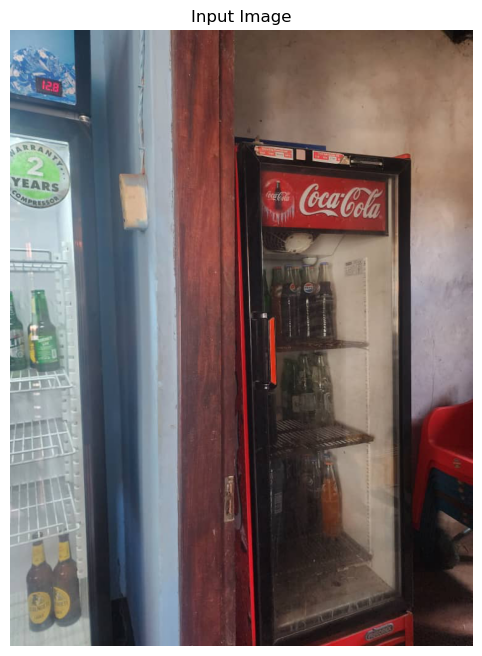

Sending request to Gemini API...
Received response from Gemini API
Response received: ```json
{
    "pepsi_count": 4,
    "kilimanjaro_count": 2,
    "detections": [
        {"product": ...
Successfully extracted JSON from response


In [ ]:
# TESTING THE FUNCTION
# Choose an inventory image to process
inventory_dir = f"{data_dir}/inventory_images"
image_file = "Customer_Stock_2025-04-30 at 12.44.33_1.jpeg"  # Change this to process a different image
image_path = os.path.join(inventory_dir, image_file)

# Detect products
results = detect_products(gemini_model, image_path)


In [91]:
def visualize_results(image_path, results):
    """Visualize detection results on the image."""
    try:
        # Read the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get image dimensions
        img_height, img_width = image.shape[:2]
        
        # Create figure and axis
        fig, ax = plt.subplots(1, figsize=(12, 9))
        ax.imshow(image)
        
        # Draw bounding boxes
        for detection in results.get("detections", []):
            product = detection.get("product", "").lower()
            x = detection.get("x", 0) * img_width / 100
            y = detection.get("y", 0) * img_height / 100
            width = detection.get("width", 0) * img_width / 100
            height = detection.get("height", 0) * img_height / 100
            
            # Create rectangle patch
            color = 'red' if 'pepsi' in product else 'green'
            rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            
            # Add label
            plt.text(x, y-5, product, color='white', fontsize=12, 
                     bbox=dict(facecolor=color, alpha=0.7))
        
        # Add counts as text
        plt.text(10, 30, f"Pepsi: {results.get('pepsi_count', 0)}", 
                 color='white', fontsize=14, bbox=dict(facecolor='red', alpha=0.7))
        plt.text(10, 70, f"Kilimanjaro: {results.get('kilimanjaro_count', 0)}", 
                 color='white', fontsize=14, bbox=dict(facecolor='green', alpha=0.7))
        
        # Remove axis ticks
        plt.axis('off')
        plt.title('Detection Results')
        
        # Show the visualization
        plt.tight_layout()
        plt.show()
        
        # Save visualization to file
        output_dir = "outputs/api"
        os.makedirs(output_dir, exist_ok=True)
        
        # Get filename without path
        filename = os.path.basename(image_path)
        output_path = os.path.join(output_dir, f"detected_{filename}")
        plt.savefig(output_path)
        print(f"Visualization saved to {output_path}")
        
    except Exception as e:
        print(f"Error visualizing results: {e}")

## 5. Viewing Sample Images

Let's first look at our sample product images to understand what we're looking for.

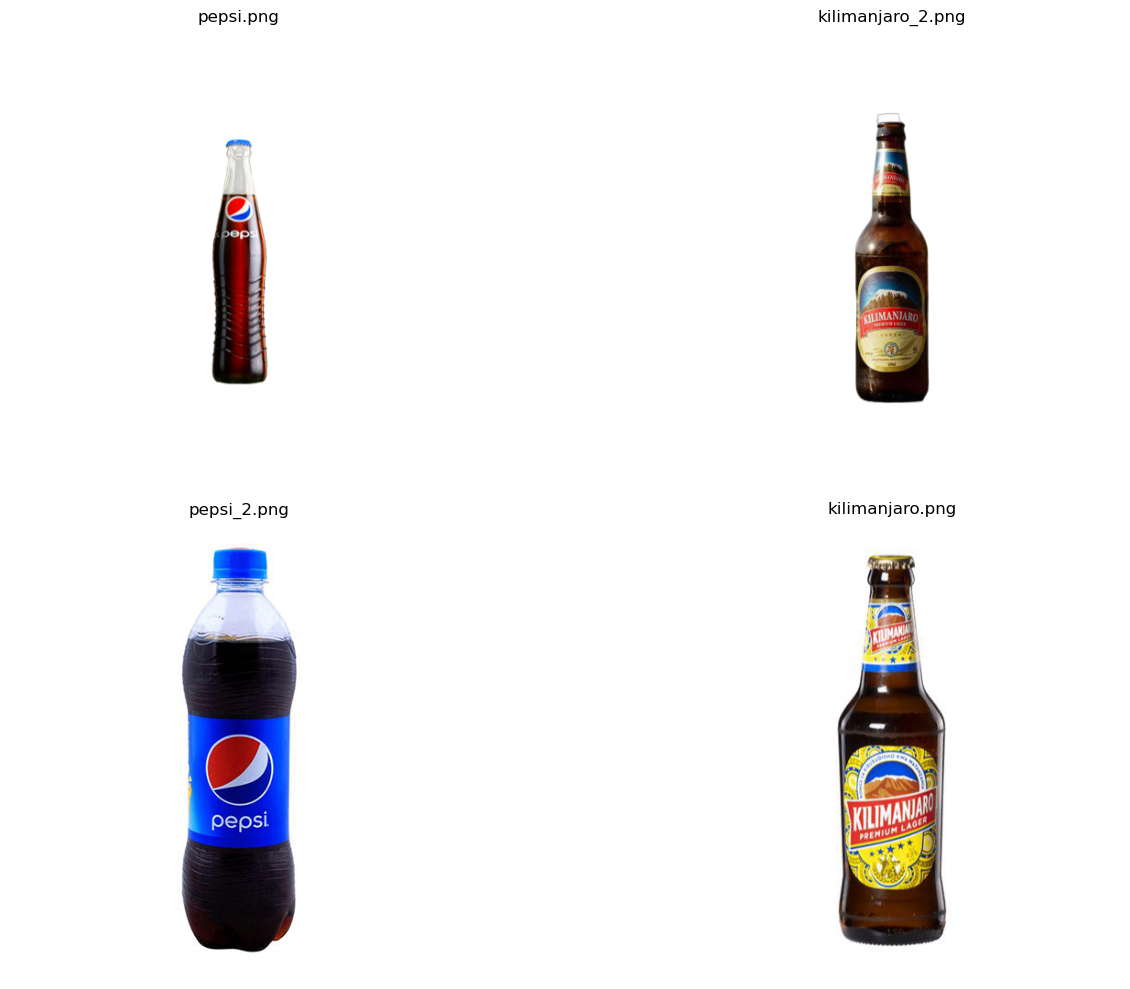

In [73]:
# Display sample images
sample_dir = f"{data_dir}/sample_images"
sample_images = [f for f in os.listdir(sample_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

plt.figure(figsize=(15, 10))
for i, image_file in enumerate(sample_images):
    image_path = os.path.join(sample_dir, image_file)
    img = Image.open(image_path)
    
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(image_file)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## 6. Process an Inventory Image

Now let's process one of the inventory images to detect products.

Loading image from /ocean/projects/cis240101p/aissah/Dftr/data/inventory_images/Customer_Stock_2025-04-30 at 12.44.35_3.jpeg
Image loaded successfully: (750, 1000)


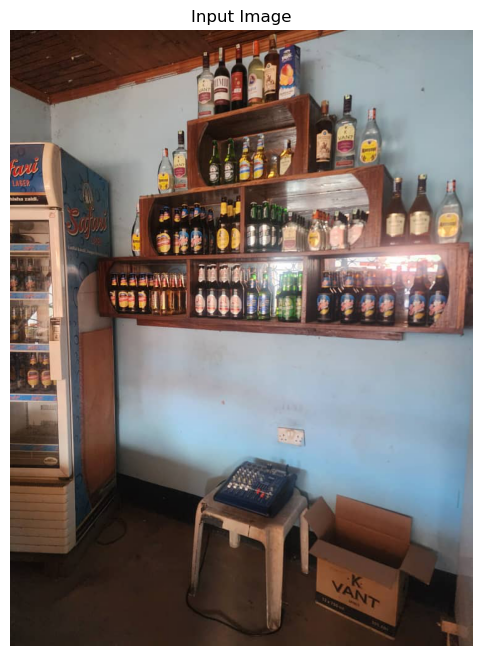

Sending request to Gemini API...
Received response from Gemini API
Response received: ```json
{
    "pepsi_count": 0,
    "kilimanjaro_count": 13,
    "detections": [
        {
         ...
Successfully extracted JSON from response

Results for Customer_Stock_2025-04-30 at 12.44.35_3.jpeg:
Pepsi count: 0
Kilimanjaro count: 13


In [ ]:
data_dir = "/ocean/projects/cis240101p/aissah/Dftr/data"
# Choose an inventory image to process
inventory_dir = f"{data_dir}/inventory_images"
image_file = "Customer_Stock_2025-04-30 at 12.44.35_3.jpeg" 
image_path = os.path.join(inventory_dir, image_file)

# Detect products
results = detect_products(gemini_model, image_path)

# Print results
print(f"\nResults for {image_file}:")
print(f"Pepsi count: {results.get('pepsi_count', 0)}")
print(f"Kilimanjaro count: {results.get('kilimanjaro_count', 0)}")

# Visualize results
visualize_results(image_path, results)

## 7. Process All Inventory Images

Let's process all inventory images and compile the results.

In [82]:
def process_all_images(model, input_dir):
    """Process all images in a directory."""
    # Get all image files
    image_files = [f for f in os.listdir(input_dir) 
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    results = {}
    
    # Process each image
    for image_file in image_files:
        image_path = os.path.join(input_dir, image_file)
        print(f"\nProcessing {image_file}...")
        
        # Detect products
        detection_results = detect_products(model, image_path)
        
        # Save results
        results[image_file] = {
            "pepsi_count": detection_results.get("pepsi_count", 0),
            "kilimanjaro_count": detection_results.get("kilimanjaro_count", 0)
        }
        
        # Visualize results
        visualize_results(image_path, detection_results)
        
        print(f"Results for {image_file}:")
        print(f"  Pepsi count: {detection_results.get('pepsi_count', 0)}")
        print(f"  Kilimanjaro count: {detection_results.get('kilimanjaro_count', 0)}")
    
    return results


Processing Customer_Stock_2025-04-30 at 12.44.34.jpeg...
Loading image from /ocean/projects/cis240101p/aissah/Dftr/data/inventory_images/Customer_Stock_2025-04-30 at 12.44.34.jpeg
Image loaded successfully: (750, 1000)


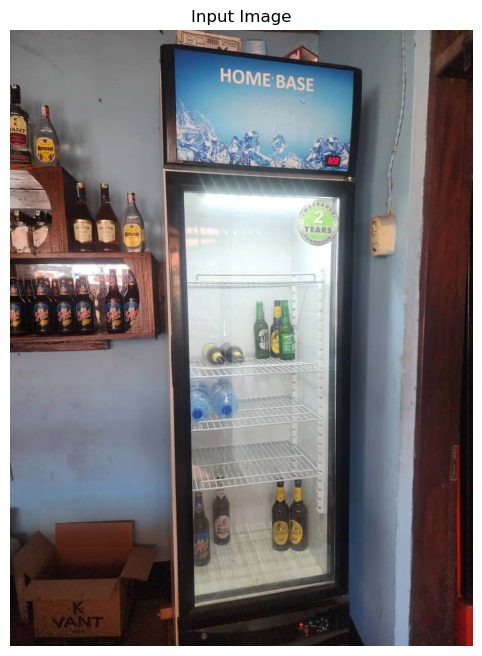

Sending request to Gemini API...
Received response from Gemini API
Response received: ```json
{
    "pepsi_count": 1,
    "kilimanjaro_count": 20,
    "detections": [
        {"product":...
Successfully extracted JSON from response


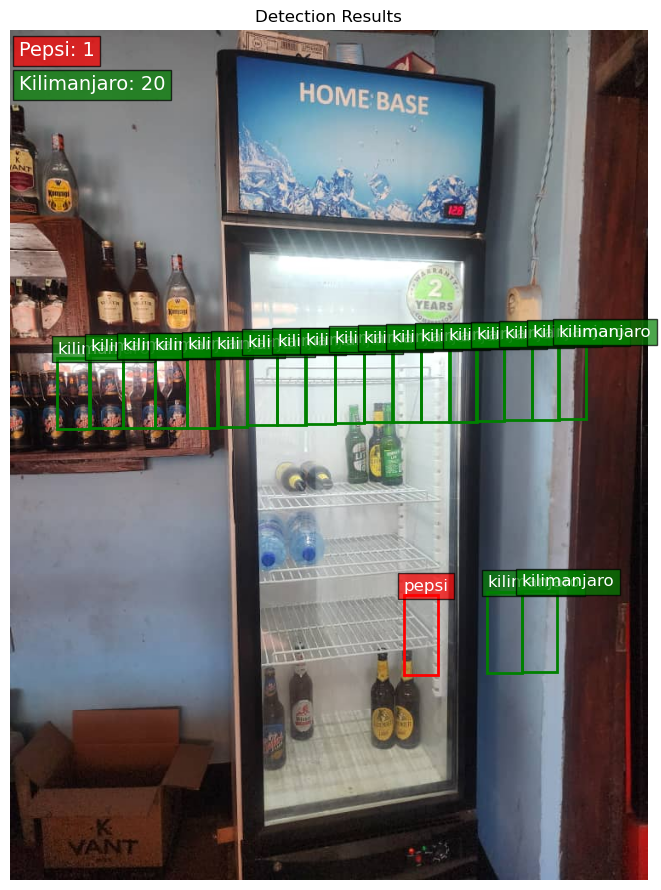

Visualization saved to outputs/api/detected_Customer_Stock_2025-04-30 at 12.44.34.jpeg
Results for Customer_Stock_2025-04-30 at 12.44.34.jpeg:
  Pepsi count: 1
  Kilimanjaro count: 20

Processing Customer_Stock_2025-04-30 at 12.44.34_2.jpeg...
Loading image from /ocean/projects/cis240101p/aissah/Dftr/data/inventory_images/Customer_Stock_2025-04-30 at 12.44.34_2.jpeg
Image loaded successfully: (750, 1000)


<Figure size 640x480 with 0 Axes>

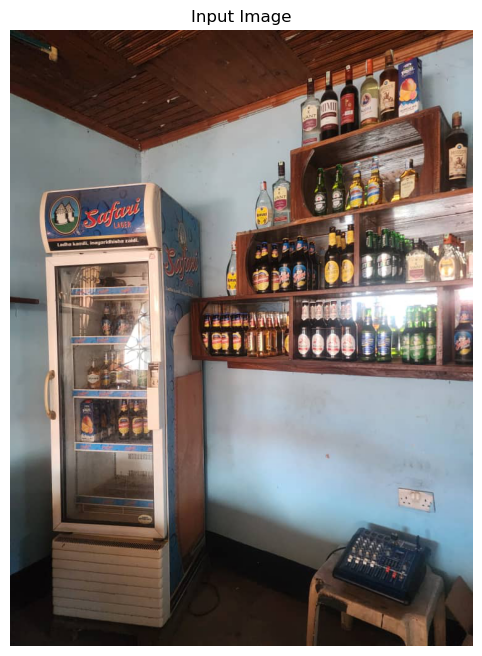

Sending request to Gemini API...
Received response from Gemini API
Response received: ```json
{
    "pepsi_count": 0,
    "kilimanjaro_count": 7,
    "detections": [
        {"product": ...
Successfully extracted JSON from response


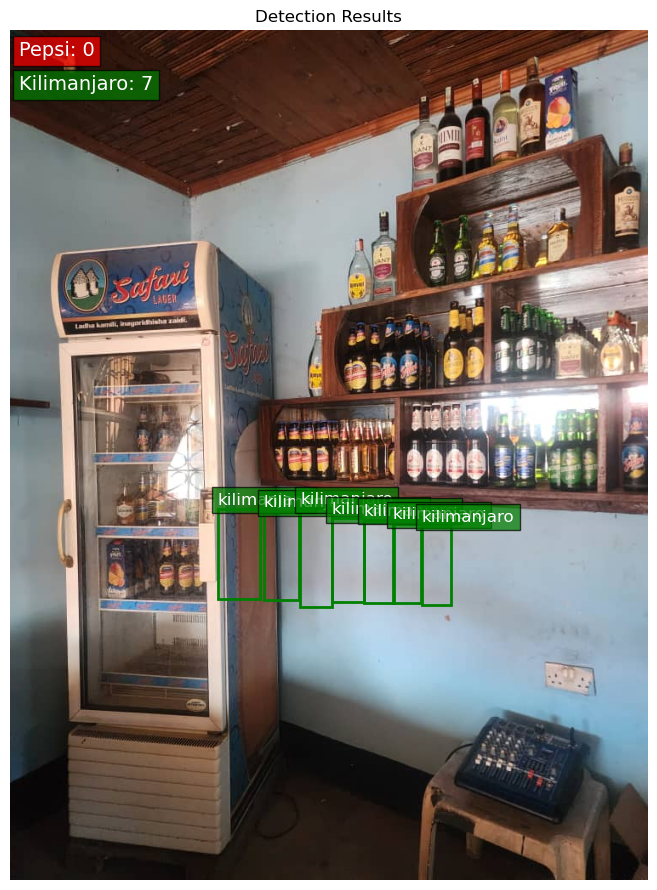

Visualization saved to outputs/api/detected_Customer_Stock_2025-04-30 at 12.44.34_2.jpeg
Results for Customer_Stock_2025-04-30 at 12.44.34_2.jpeg:
  Pepsi count: 0
  Kilimanjaro count: 7

Processing Customer_Stock_2025-04-30 at 12.44.33_1.jpeg...
Loading image from /ocean/projects/cis240101p/aissah/Dftr/data/inventory_images/Customer_Stock_2025-04-30 at 12.44.33_1.jpeg
Image loaded successfully: (750, 1000)


<Figure size 640x480 with 0 Axes>

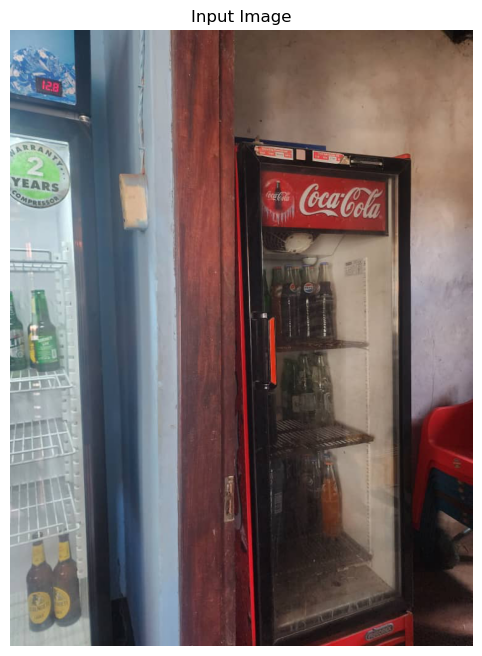

Sending request to Gemini API...
Received response from Gemini API
Response received: ```json
{
    "pepsi_count": 4,
    "kilimanjaro_count": 2,
    "detections": [
        {"product": ...
Successfully extracted JSON from response


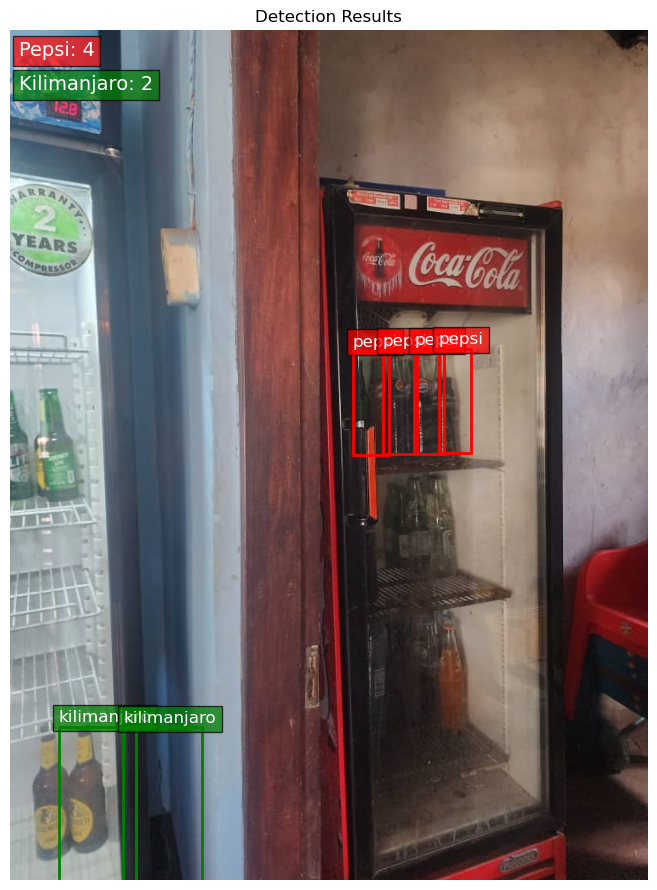

Visualization saved to outputs/api/detected_Customer_Stock_2025-04-30 at 12.44.33_1.jpeg
Results for Customer_Stock_2025-04-30 at 12.44.33_1.jpeg:
  Pepsi count: 4
  Kilimanjaro count: 2

Processing Customer_Stock_2025-04-30 at 12.44.33.jpeg...
Loading image from /ocean/projects/cis240101p/aissah/Dftr/data/inventory_images/Customer_Stock_2025-04-30 at 12.44.33.jpeg
Image loaded successfully: (750, 1000)


<Figure size 640x480 with 0 Axes>

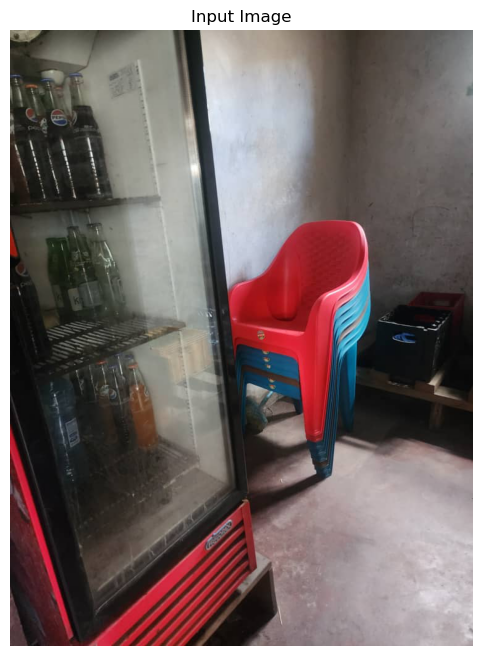

Sending request to Gemini API...
Received response from Gemini API
Response received: ```json
{
    "pepsi_count": 6,
    "kilimanjaro_count": 4,
    "detections": [
        {"product": ...
Successfully extracted JSON from response


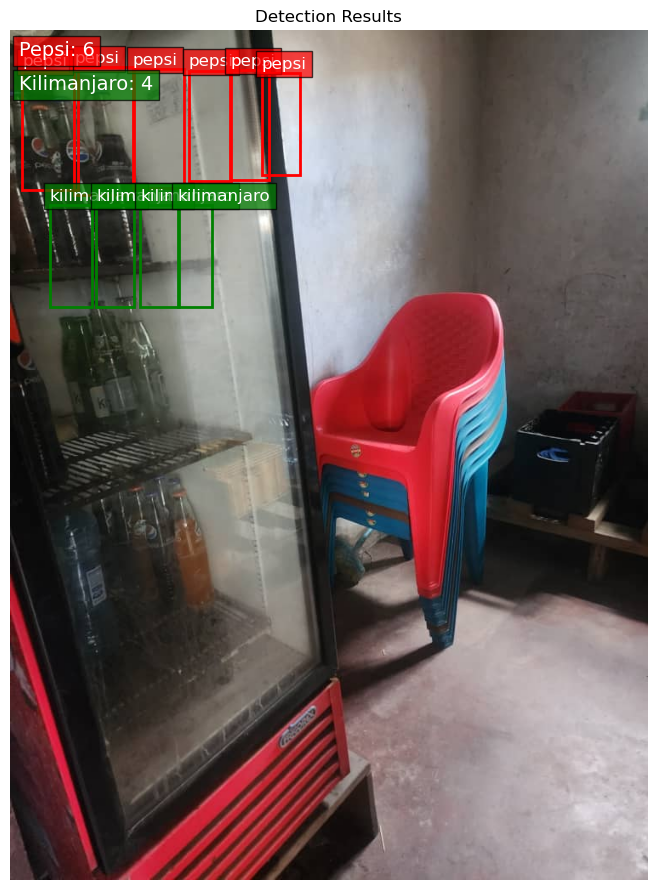

Visualization saved to outputs/api/detected_Customer_Stock_2025-04-30 at 12.44.33.jpeg
Results for Customer_Stock_2025-04-30 at 12.44.33.jpeg:
  Pepsi count: 6
  Kilimanjaro count: 4

Processing Customer_Stock_2025-04-30 at 12.44.35_3.jpeg...
Loading image from /ocean/projects/cis240101p/aissah/Dftr/data/inventory_images/Customer_Stock_2025-04-30 at 12.44.35_3.jpeg
Image loaded successfully: (750, 1000)


<Figure size 640x480 with 0 Axes>

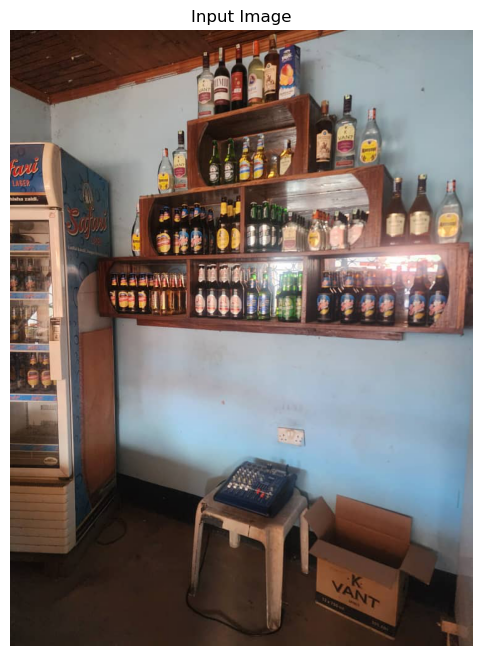

Sending request to Gemini API...
Received response from Gemini API
Response received: ```json
{
    "pepsi_count": 0,
    "kilimanjaro_count": 31,
    "detections": [
        {"product":...
Successfully extracted JSON from response


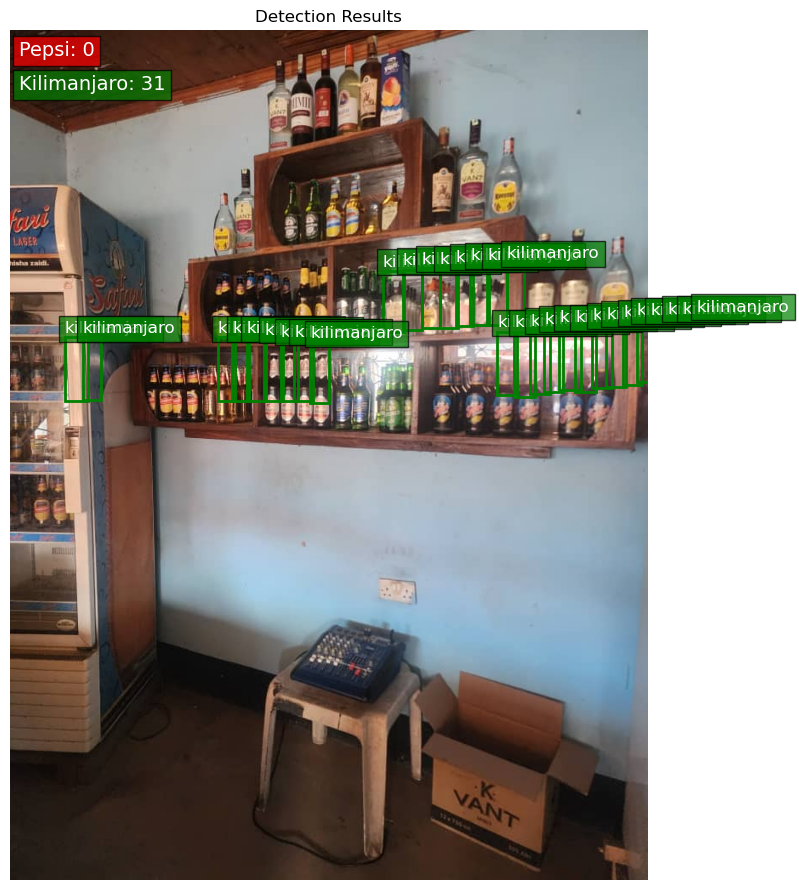

Visualization saved to outputs/api/detected_Customer_Stock_2025-04-30 at 12.44.35_3.jpeg
Results for Customer_Stock_2025-04-30 at 12.44.35_3.jpeg:
  Pepsi count: 0
  Kilimanjaro count: 31

Summary results saved to outputs/api/summary_results.json


<Figure size 640x480 with 0 Axes>

In [83]:
# Process all images in the inventory directory
all_results = process_all_images(gemini_model, inventory_dir)

# Save results to JSON
output_dir = "outputs/api"
os.makedirs(output_dir, exist_ok=True)
summary_path = os.path.join(output_dir, "summary_results.json")

with open(summary_path, 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"\nSummary results saved to {summary_path}")

## 8. Analyze Results

Let's visualize the results across all images.

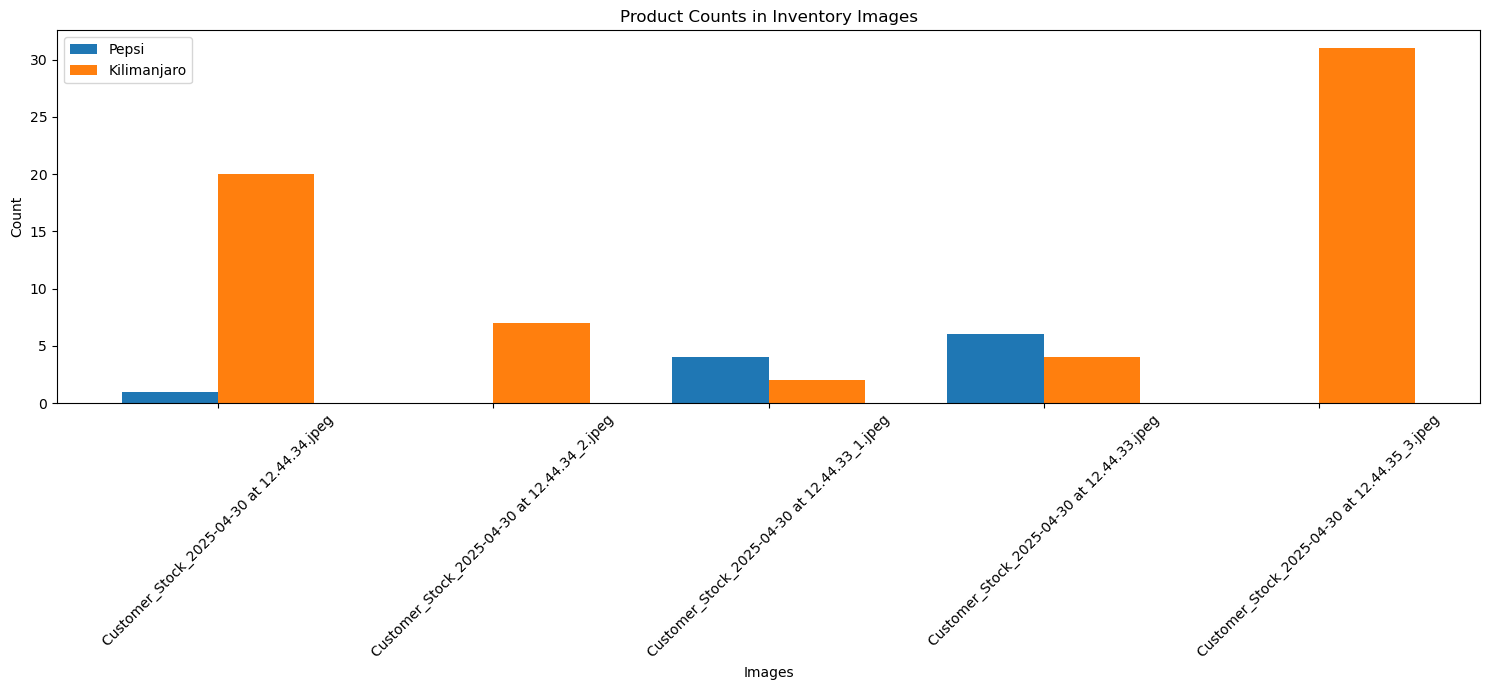

In [88]:
# Create a summary visualization

image_names = list(all_results.keys())
pepsi_counts = [all_results[img]['pepsi_count'] for img in image_names]
kilimanjaro_counts = [all_results[img]['kilimanjaro_count'] for img in image_names]

# Plot
plt.figure(figsize=(15, 7))
x = range(len(image_names))
width = 0.35

plt.bar([i - width/2 for i in x], pepsi_counts, width, label='Pepsi')
plt.bar([i + width/2 for i in x], kilimanjaro_counts, width, label='Kilimanjaro')

plt.xlabel('Images')
plt.ylabel('Count')
plt.title('Product Counts in Inventory Images')
plt.xticks(x, [img for img in image_names], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()